In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import copy
from skimage.transform import radon, iradon
from math import floor
from IPython.display import HTML
from matplotlib import animation

import gvxrPython3 as gvxr
import json2gvxr # Set gVirtualXRay and the simulation up

SimpleGVXR 1.0.1 (2021-09-14T09:45:26) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-09-14T09:45:19) [Compiler: GNU g++] on Linux


Define constants for this experiment

In [2]:
number_of_projections = 360;
number_of_projections_to_visualize = 25; #floor(number_of_projections/2);
ray_energy = 73; 
angular_step = 180 / number_of_projections;
pixel_spacing_in_micrometre = 0.625;

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [3]:
json2gvxr.initGVXR("notebook-9.json", "OPENGL")

Create an OpenGL context: 512x512


## X-ray source

We create an X-ray source. It is a parallel source.

In [4]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0, -500, 0, 'mm']
	Source shape: ParallelBeam


## Spectrum

The spectrum is monochromatic.

In [5]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=0)

## Detector

Create a digital detector

In [6]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0, 500, 0, 'mm']
	Detector up vector: [0, 0, 1]
	Detector number of pixels: [150, 100]
	Pixel spacing: [0.625, 0.625, 'cm']


## Scanned object

We create a cylinder. Its linear attenuation coefficient is 0.5 cm<sup>-1</sup>. The cylinder is within  a cube whose linear attenuation coefficient is 0.1 cm<sup>-1</sup>.

In [7]:
json2gvxr.initSamples(verbose=1)

Load the 3D data

Cube is a cube
Cylinder is a cylinder


## Runing the simulation

Update the 3D visualisation and take a screenshot

In [8]:
ggvxr.displayScene()

gvxr.useLighing()
gvxr.useWireframe()
gvxr.setZoom(1837.098388671875)
gvxr.setSceneRotationMatrix([0.48896607756614685, 0.2033134251832962, -0.8482770919799805, 0.0, -0.8596474528312683, 0.2773565351963043, -0.4290446639060974, 0.0, 0.14804469048976898, 0.9390085339546204, 0.3103960156440735, 0.0, 0.0, 0.0, 0.0, 1.0])

gvxr.displayScene()

687.098388671875
(0.9603984951972961, -0.10599623620510101, -0.25768256187438965, 0.0, -0.22845378518104553, 0.22988736629486084, -0.9460226893424988, 0.0, 0.15951277315616608, 0.9674263000488281, 0.19656720757484436, 0.0, 0.0, 0.0, 0.0, 1.0)


In [9]:
screenshot = gvxr.takeScreenshot()

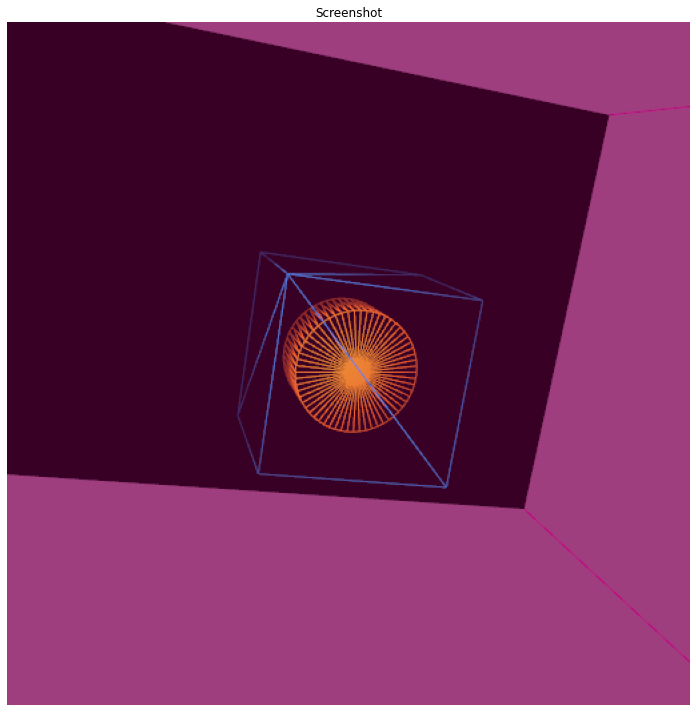

In [10]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-off-simple_CT.pdf')
plt.savefig('plots/screenshot-beam-off-simple_CT.png')

Update set of projections while rotating the scene to mimick CT acquisition

In [11]:
raw_projections = [];
theta = [];
#im = plt.imshow(raw_projections[0], animated=True)

for angle_id in range(0, number_of_projections):
    gvxr.rotateScene(-angular_step, 0, 0, 1);
    theta.append(-angular_step * angle_id);
    #gvxr.displayScene();
    
    xray_image = np.array(gvxr.computeXRayImage());
    raw_projections.append(xray_image);
    #plt.imshow(xray_image, cmap='gray');
    
raw_projections = np.array(raw_projections);
raw_projections = raw_projections / gvxr.getUnitOfEnergy("keV");




plt.imshow(raw_projections[projectionToVis], cmap='gray');
#gvxr.renderLoop();

NameError: name 'projectionToVis' is not defined

Perform flat-field correction

In [ ]:
# Create a mock dark field image
dark_field_image = np.zeros(raw_projections.shape);

# Create a mock flat field image
flat_field_image = np.ones(raw_projections.shape);

# Retrieve the total energy
total_energy = 0.0;
energy_bins = gvxr.getEnergyBins("keV");
photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

for energy, count in zip(energy_bins, photon_count_per_bin):
    total_energy += energy * count;
flat_field_image *= total_energy;
    
# Apply the actual flat-field correction on the raw projections
corrected_projections = (raw_projections - dark_field_image) / (flat_field_image - dark_field_image);
    
plt.imshow(corrected_projections[projectionToVis], cmap='gray');

Do inverse log

In [ ]:

# Create a temporary image to hold the sinogram
simulated_sinogram = copy.deepcopy(corrected_projections);
    
# Make sure no value is negative or null (because of the log function)
# It should not be the case, however, when the Laplacian is used to simulate
# phase contrast, negative values can be generated.
threshold = 0.000000001
simulated_sinogram[simulated_sinogram < threshold] = threshold;

# Apply the minus log normalisation
simulated_sinogram = -np.log(simulated_sinogram);

# Rescale the data taking into account the pixel size
simulated_sinogram /= pixel_spacing_in_micrometre * (gvxr.getUnitOfLength("um") / gvxr.getUnitOfLength("cm"));
simulated_sinogram = np.swapaxes(simulated_sinogram, 0, 1); # slices as sinograms

plt.imshow(simulated_sinogram[projectionToVis], cmap='gray');

Reconstruct the CT slice

In [ ]:
CT_slice_from_simulated_sinogram = [];
   
#Lets reconstruct the centre slice
slice = len(simulated_sinogram) / 2;

print("reconstructing slice # ", slice);
CT_slice_from_simulated_sinogram.append(iradon(simulated_sinogram[slice].T, theta=theta, circle=True));
       
# Save the CT slice
CT_slice_from_simulated_sinogram = np.array(CT_slice_from_simulated_sinogram);
    
    
    
volume = sitk.GetImageFromArray(CT_slice_from_simulated_sinogram);
volume.SetSpacing([0.625, 0.625, 0.7]);
sitk.WriteImage(volume, "recon_in_MU.mha", useCompression=True);


Transform pixels to obtain a slice measured in HU

In [ ]:
MU_air = gvxr.getMuFromHU(-1000.0, rayEnergy, "keV");
#MU_water = 1.707*0.1;
MU_water = gvxr.getMuFromHU(0, rayEnergy, "keV");
    
print("mu air", MU_air);
print("mu water", MU_water);
copied = copy.deepcopy(CT_slice_from_simulated_sinogram);
CT_slice_from_simulated_sinogram = 1000.0 * ((copied - MU_water) / (MU_water - MU_air));
    
volume = sitk.GetImageFromArray(CT_slice_from_simulated_sinogram);
volume.SetSpacing([0.625, 0.625, 0.7]);
sitk.WriteImage(volume, "recon_in_HU.mha", useCompression=True);
plt.imshow(CT_slice_from_simulated_sinogram[0], cmap='gray');